In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from tqdm import tqdm
import numpy as np
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import json
import warnings
warnings.filterwarnings("ignore")

In [ ]:
with open('/content/drive/MyDrive/Colab_Notebooks/team_classification_data/bboxes.json') as f:
  data = json.load(f)

In [ ]:
list(data.keys())[1]

'1577'

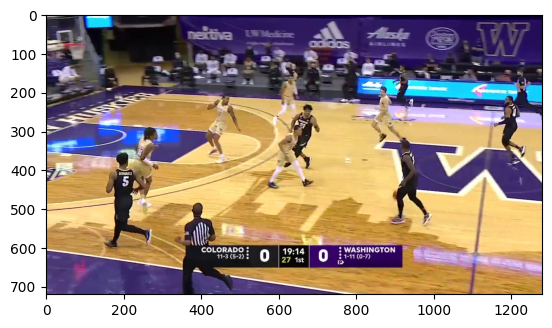

In [ ]:
img = cv.imread(f'/content/drive/MyDrive/Colab_Notebooks/team_classification_data/frames/{list(data.keys())[1]}.jpeg', cv.IMREAD_COLOR)
img = img[...,::-1]
plt.imshow(img)

In [ ]:
img1 = img.copy()

In [ ]:
def convert_size(path):
  with open(path) as f:
    data = json.load(f)
  new_data = data.copy()
  X = 1280
  Y = 720
  for key in new_data.keys():
    for key2 in new_data[key]:

      Xx = new_data[key][key2]['box'][0] * X
      Yy = new_data[key][key2]['box'][1] * Y

      new_data[key][key2]['box'][0] = abs(round(Xx))
      new_data[key][key2]['box'][1] = abs(round(Yy))

      new_data[key][key2]['box'][2] = abs(round(Xx + new_data[key][key2]['box'][2] * X))
      new_data[key][key2]['box'][3] = abs(round(Yy + new_data[key][key2]['box'][3] * Y))
  return new_data

### Visualize

In [ ]:
new_data = convert_size('/content/drive/MyDrive/Colab_Notebooks/team_classification_data/bboxes.json')

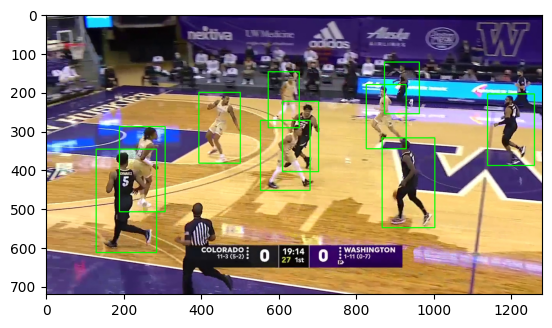

In [ ]:
for v in new_data['1577'].values():
  a = cv.rectangle(img1,(v['box'][0], v['box'][1]),(v['box'][2], v['box'][3]),(0,255,0),2)
  # print(v['box'])
plt.imshow(a)

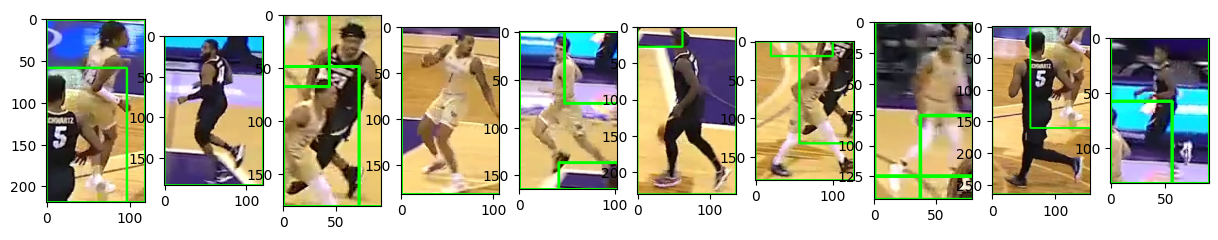

In [ ]:
fig, (axes) = plt.subplots(1,10, figsize=(15,40))
for i, v in enumerate(new_data['1577'].values()):
  axes[i].imshow(img1[v['box'][1]:v['box'][3], v['box'][0]:v['box'][2], :])

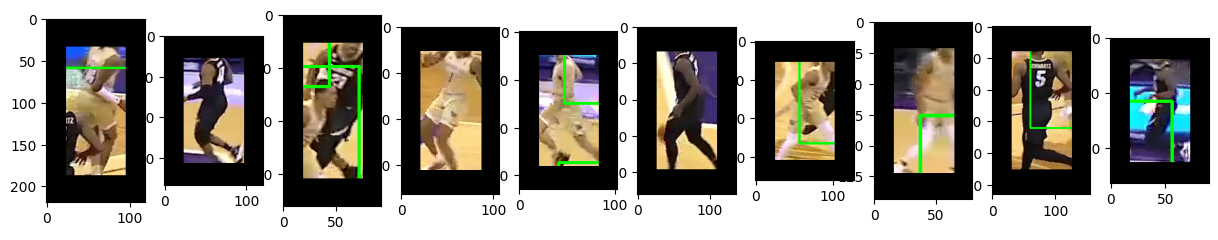

In [ ]:
fig, (axes) = plt.subplots(1,10, figsize=(15,40))
for i, v in enumerate(new_data['1577'].values()):

  crop = img1[v['box'][1]:v['box'][3], v['box'][0]:v['box'][2], :]
  mask = np.zeros(crop.shape[:2], dtype="uint8")

  a1 = abs(round(mask.shape[1] * 0.2))
  b1 = abs(round(mask.shape[0] * 0.15))

  a2 = abs(round(mask.shape[1] - a1))
  b2 = abs(round(mask.shape[0] - b1))

  cv.rectangle(mask, (a1, b1), (a2, b2), 255, -1)
  masked = cv.bitwise_and(crop, crop, mask=mask)
  axes[i].imshow(masked)

In [ ]:
def get_channel(type_data:str, train_or_test, new_data):
  new_data2 = new_data.copy()
  if type_data == 'hsv':
    for key in tqdm(new_data2.keys()):
      for val in new_data2[key].values():
        hist = []
        img = cv.imread(f'/content/drive/MyDrive/Colab_Notebooks/team_classification_{train_or_test}/frames/{key}.jpeg')
        img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
        region = img[val['box'][1]:val['box'][3], val['box'][0]:val['box'][2]]

        mask = np.zeros(region.shape[:2], dtype="uint8")
        a1 = abs(round(mask.shape[1] * 0.2))
        b1 = abs(round(mask.shape[0] * 0.15))

        a2 = abs(round(mask.shape[1] - a1))
        b2 = abs(round(mask.shape[0] - b1))

        S = mask.shape[0] * mask.shape[1]

        cv.rectangle(mask, (a1, b1), (a2, b2), 255, -1)
        masked = cv.bitwise_and(region, region, mask=mask)
        h, s, v = np.mean(masked, axis=(0, 1))
        val['hsv'] = [h,s,v]

        for i in range(3):
          hist.append(cv.calcHist([img],[i],None,[2],[0,256]).tolist())
          list_rgb = []
          for i in hist:
            list_rgb.append([item for sublist in i for item in sublist])
        hvs_list = list(itertools.chain.from_iterable(list_rgb))
        val['hsv_hist']= [x / S for x in hvs_list]

  if type_data == 'rgb':
    for key in tqdm(new_data2.keys()):
      for v in new_data2[key].values():
        hist = []
        img = cv.imread(f'/content/drive/MyDrive/Colab_Notebooks/team_classification_{train_or_test}/frames/{key}.jpeg', \
                        cv.IMREAD_COLOR)
        img = img[...,::-1]
        region = img[v['box'][1]:v['box'][3], v['box'][0]:v['box'][2]]

        mask = np.zeros(region.shape[:2], dtype="uint8")
        a1 = abs(round(mask.shape[1] * 0.2))
        b1 = abs(round(mask.shape[0] * 0.15))

        a2 = abs(round(mask.shape[1] - a1))
        b2 = abs(round(mask.shape[0] - b1))

        S = mask.shape[0] * mask.shape[1]

        cv.rectangle(mask, (a1, b1), (a2, b2), 255, -1)
        masked = cv.bitwise_and(region, region, mask=mask)
        r, g, b = np.mean(masked, axis=(0, 1))
        v['rgb'] = [r,g,b]

        for i in range(3):
          hist.append(cv.calcHist([img],[i],None,[2],[0,256]).tolist())
          list_rgb = []
          for i in hist:
            list_rgb.append([item for sublist in i for item in sublist])
        rgb_list = list(itertools.chain.from_iterable(list_rgb))
        v['rgb_hist']= [x / S for x in rgb_list]
  return new_data2


In [ ]:
def accuracy(type_data:str,
                   type_data2:str, data):

# type_data: пространство rgb или hsv
# type_data2: тип вектора признаков(rgb, hsv, rgb_hist, hsv_hist)

  new_data2=get_channel(type_data, 'data', data)
  acc_train = []
  acc_test = []
  image_list =[]
  for i in new_data2.keys():
    image_list.append(i)

  team_list = []
  for img in image_list:
    for k, v in new_data2[img].items():
      team_list.append(v['team'])

  team_lists = np.array_split(team_list, 100)
  pred_lists = []
  for img in image_list:
    labels =[]
    X=[]
    X_list = []
    for i in new_data2[img].values():
      if type_data2 == 'hsv':
        X.append(i['hsv'])
      if type_data2 == 'rgb':
        X.append(i['rgb'])
      if type_data2 == 'rgb_hist':
        X.append(i['rgb_hist'])
      if type_data2 == 'hsv_hist':
        X.append(i['hsv_hist'])
    X=np.array(X)
    X_list.append(X)

    kmeans = KMeans(n_clusters=2).fit(X)
    pred = kmeans.labels_
    pred_lists.append(pred)

    for x,y in zip(X_list, team_lists):
      model = RandomForestClassifier(max_depth=1, random_state=0, n_estimators=50)
      model.fit(X[:7], y[:7])
      acc_train.append(accuracy_score(y,model.predict(X)))
      acc_test.append(accuracy_score(y[7:],model.predict(X[7:])))

  accuracy_list = []
  for label, pred in zip(team_lists, pred_lists):
    correct = (label == pred)
    accuracy = correct.sum() / correct.size
    if accuracy < 0.5:
      for i in range(len(pred)):
        if pred[i] == 0:
            pred[i] = 1
        else:
            pred[i] = 0
      correct = (label == pred)
      accuracy = correct.sum() / correct.size
      accuracy_list.append(accuracy)
    else:
      accuracy_list.append(accuracy)

  return np.mean(accuracy_list), np.mean(acc_train), np.mean(acc_test)

In [ ]:
accuracy('rgb', 'rgb', new_data)

100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


(0.8360000000000001, 0.7789999999999999, 0.5533333333333333)